In [1]:
!nvidia-smi

Thu Jun 13 15:23:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB-LS        Off | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0              42W / 163W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import sys
sys.path.append(f'/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/mae')

In [3]:
import models_lib
import torchvision.transforms as transforms
import torch
import numpy as np
import timm
import matplotlib.pyplot as plt
from dataset_mae import MAEDataset


In [4]:
MEAN_CLIPORT = [0.48145466, 0.4578275, 0.40821073]
STD_CLIPORT = [0.26862954, 0.26130258, 0.27577711]
TEST_PATH = '/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/data_hdf5/exist_dataset_no_aug_all_test.hdf5'
MODEL = 'mae_robot_lang_relevance'
CHECKPOINT = '/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/output_mae_robot_lang_relevance/checkpoint-80.pth'
device = 'cuda'

In [5]:
def get_fix_transform():
    trasform_fix = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN_CLIPORT, std=STD_CLIPORT)])
    return trasform_fix

def generate_token(text_processor, lang, device):
    if type(lang) is str:
        decoded_strings = [lang]
    else:
        decoded_strings = [s.decode('ascii') for s in lang]
    processed_lang = text_processor(text=decoded_strings, padding="max_length", return_tensors='pt')
    processed_lang = processed_lang.to(device)
    return processed_lang

In [6]:
# load data and model
transform_train = get_fix_transform()
dataset_vis = MAEDataset(transform=transform_train, data_path=TEST_PATH)
model = models_lib.__dict__[MODEL](norm_pix_loss=False)
model.to(device)
checkpoint = torch.load(CHECKPOINT, map_location='cpu')
model.load_state_dict(checkpoint['model'])

Length of the dataset:  8633


/jmain02/home/J2AD007/txk47/cxz00-txk47/.conda/envs/mae-cliport/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<All keys matched successfully>

In [7]:
from transformers import AutoTokenizer
text_processor = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [31]:
from torch.utils.data import DataLoader, Subset
import cv2

def get_random_batch(idx):
    subset_indices = [idx]
    subset = Subset(dataset_vis, subset_indices)
    subset_loader = DataLoader(subset, batch_size=1, shuffle=False)
    batch = next(iter(subset_loader))
    return batch

def show_image_relevance(image_relevance, image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)    
    image = (image - image.min()) / (image.max() - image.min())
    image = image[0].permute(1, 2, 0).cpu().numpy()    
    axs[0].imshow(image);
    axs[0].axis('off');
    
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image_relevance = image_relevance[0].permute(1, 2, 0).data.cpu().numpy()

    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [32]:
TESTSET_IDX = [0,716,1216,1716,2205,2694,2928,3205,3305,3535,3757,3924,4091,5015,5933,6570,7207,7920,8633]

(-0.5, 159.5, 319.5, -0.5)

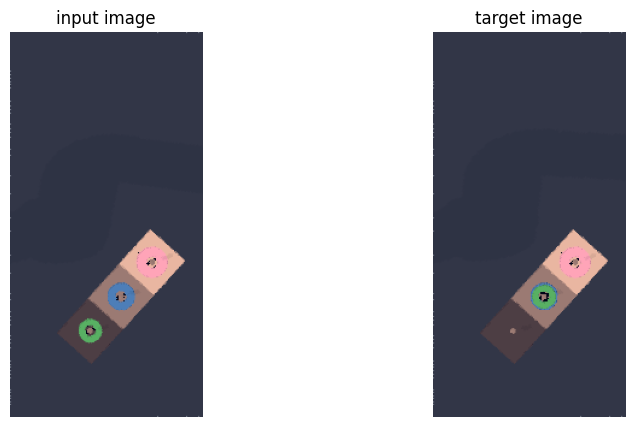

In [109]:
batch = get_random_batch(TESTSET_IDX[-2]+2)

img1, img2, lang, pick, place = batch
img1 = img1.to(device, non_blocking=True).float()
img2 = img2.to(device, non_blocking=True).float()
pick = pick.to(device, non_blocking=True).float()
place = place.to(device, non_blocking=True).float()

img1_show = (img1 - img1.min()) / (img1.max() - img1.min())
img2_show = (img2 - img2.min())/ (img2.max() - img2.min())
img1_show = img1_show[0].permute(1, 2, 0).cpu().numpy()
img2_show = img2_show[0].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_show)
plt.title('input image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_show)
plt.title('target image')
plt.axis('off')


original lang is (b'move the green ring to the middle of the stand',)
Please input your lang ...
move the blue ring to the darker brown side


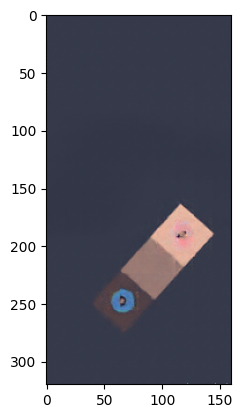

In [111]:
print(f"original lang is {lang}")
print("Please input your lang ...")
input_lang = input()
lang_input = input_lang if input_lang else lang
lang_processed = generate_token(text_processor, lang_input, device)
    
loss, predict, mask = model(img1, img2, pick, place, lang_processed, mask_ratio=0.95)
predict = model.unpatchify(predict)
predict = predict.detach().cpu()
predict = predict[0]
predict = (predict - predict.min()) / (predict.max() - predict.min())
predict = predict.permute(1, 2, 0).numpy()

plt.imshow(predict)



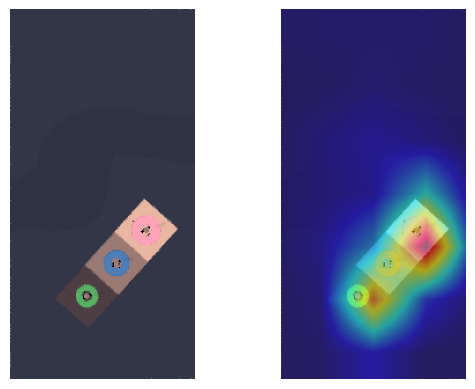

In [108]:
relevance = model.show_relevance_map(img1,lang_processed)
show_image_relevance(relevance, img1)

In [80]:
import torch
from torchvision import transforms
from PIL import Image
def load_image_to_tensor(image_path):
    """
    Load an image from the specified path and convert it to a PyTorch tensor.

    Args:
        image_path (str): The path to the image file.

    Returns:
        torch.Tensor: The image converted to a PyTorch tensor.
    """
    # Define the transform to convert the image to a tensor
    transform = transforms.Compose([
        transforms.Resize((320, 160)),
        transforms.ToTensor()
    ])

    # Load the image
    image = Image.open(image_path)

    # Apply the transform to the image
    image_tensor = transform(image)

    # Optional: Move the tensor to GPU if available
    if torch.cuda.is_available():
        image_tensor = image_tensor.to('cuda')
        print('Tensor moved to GPU')
    
    return image_tensor

Tensor moved to GPU
the man wearing glasses


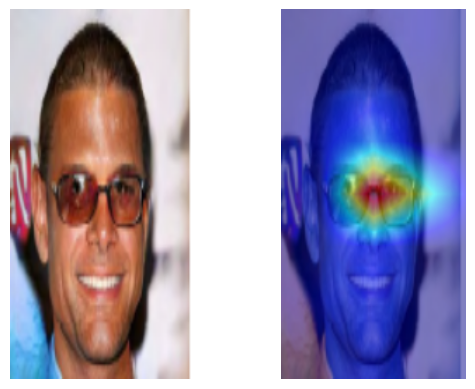

In [68]:
img_input = load_image_to_tensor('/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/glasses.png')
img_input = img_input.unsqueeze(0)
input_lang = input()
lang_processed =generate_token(text_processor, input_lang, device)
relevance = model.show_relevance_map(img_input,lang_processed)
show_image_relevance(relevance, img_input)

Tensor moved to GPU
test


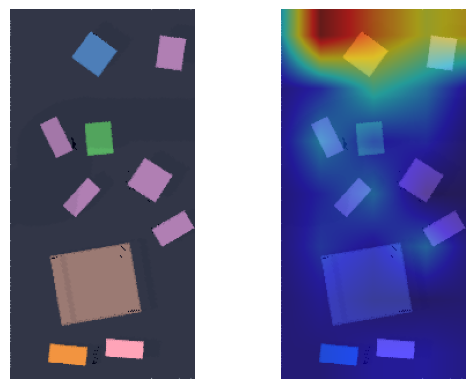

In [59]:
img_input = load_image_to_tensor('/jmain02/home/J2AD007/txk47/cxz00-txk47/DiffPort/data_gt_real_images/real0.png')
img_input = img_input.unsqueeze(0)


In [14]:
img_input.shape

torch.Size([1, 3, 320, 160])

the red plate


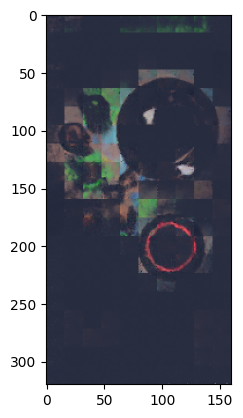

In [46]:
input_lang = input()
lang_processed = generate_token(text_processor, lang_input, device)

with torch.no_grad():
    
    loss, predict, mask = model(img_input, img_input, pick, place, lang_processed, mask_ratio=0.95)
    predict = model.unpatchify(predict)
    predict = predict.detach().cpu()
    predict = predict[0]
    predict = (predict - predict.min()
            ) / (predict.max() - predict.min())
    predict = predict.permute(1, 2, 0).numpy()

plt.imshow(predict)